# A Monte Carlo Option Pricing Model Incorporating Non-Constant Volatility
Basic Setup of the Heston model: Expanding the Black-Scholes framework for when the constant volatility model is unsuitable. Letting both the underlying security's price, $S_t$ as well as the volatility, $V_t$, modelled by stochastic differential equations, two Wiener processes.

$dS_t = \mu S_tdt + \sqrt{V_t}S_tdW^1_t$


$dV_t = \kappa (\theta - V_t)dt + \sigma \sqrt{V_t}dW_t^2$

Realistically only have data on American Options so I'll have to make due with this. 
Problems:
* Esp. on dividend-paying stocks it causes problems -> Selecting non-dividend paying companies from S&P 500.
* Heston model because of its stochastic volatility has a greater pricing difference between European and American Call options compared to, say, Black-Scholes. The closed-form solution, even though I want to test divergence, but we're just gonna have to do it really scuffed

In [2]:
import numpy as np
from scipy.integrate import quad
import cmath

In [92]:
import yfinance as yf
import pandas as pd
from datetime import datetime

selected_tickers = ['AMD']

# Dictionary to hold DataFrames for each ticker
option_data_dict = {}

# Fetch historical stock and option data
for ticker in selected_tickers:
    stock_data = yf.Ticker(ticker)
    
    print(stock_data.options)
    furthest_expiry = stock_data.options[14]
    
    # Fetch historical option data for the nearest expiration date
    options = stock_data.option_chain(furthest_expiry)
    calls = options.calls
    selected_calls = calls[['strike', 'lastPrice']]  
    
    expiry_date = datetime.strptime(furthest_expiry, '%Y-%m-%d')
    today = datetime.today()
    time_to_expiry = (expiry_date - today).days
    
    selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)
    
    option_data_dict[ticker] = selected_calls.reset_index(drop=True)



('2023-09-01', '2023-09-08', '2023-09-15', '2023-09-22', '2023-09-29', '2023-10-06', '2023-10-20', '2023-11-17', '2023-12-15', '2024-01-19', '2024-02-16', '2024-03-15', '2024-04-19', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19')


C:\Users\oscar\AppData\Local\Temp\ipykernel_11876\308696641.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_calls['Time to Expiry (days)'] = [time_to_expiry] * len(selected_calls)


In [93]:
option_data_df = pd.concat(option_data_dict, names=['Ticker', 'Option']).reset_index(level=1, drop=True)
stock_data_df = pd.concat(stock_data_dict, names=['Ticker', 'Date']).reset_index(level=1, drop=False)
option_data_df.head()

,strike,lastPrice,Time to Expiry (days)
Ticker,,,
AMD,30.0,77.17,388
AMD,35.0,71.97,388
AMD,40.0,67.26,388
AMD,45.0,63.85,388
AMD,50.0,56.82,388


Moneyness: You can still examine how well the model prices options at different levels of "moneyness" (i.e., the relationship between the stock price and the option's strike price).

Implied Volatility Surface: You can use the model to generate an implied volatility surface from the single option chain and compare it to the actual market implied volatilities.

Sensitivity Analysis: You can perform a sensitivity analysis to see how changes in the model parameters affect option prices.

Benchmarking: You can compare the Heston model's prices to those from simpler models like Black-Scholes to see if the added complexity of the Heston model provides any benefits for the specific option chain you're examining.

Risk Metrics: You can calculate risk metrics like the Greeks (Delta, Gamma, Vega, etc.) to see how they compare to market values.

In [65]:
option_data_df.to_csv("option_data.csv")
stock_data_df.to_csv("stock_data.csv")

In [91]:
S_0 = stock_data_df['Close'].iloc[-1]
stock_data_df['Daily_Return'] = stock_data_df['Close'].pct_change()
historical_volatility = np.std(stock_data_df['Daily_Return'].dropna()) * np.sqrt(252)  # Annualized
r_f = 0.053 # Apprx. the short-term treasury rate, just the 3-month yield

In [89]:
v_0_estimated = historical_volatility**2  
theta_estimated = historical_volatility**2

# 2. Mean Reversion Speed (kappa)
# eh, we'll throw in a parameter like 1 as an educated guess
kappa_estimated = 1.0

# 3. Volatility of Volatility (sigma)
# Calculating the rolling standard deviation of daily returns and then its standard deviation
window_size = 21  # Approx. one trading month
rolling_volatility = stock_data_df['Daily_Return'].rolling(window=window_size).std() * np.sqrt(252)  # Annualized
sigma_estimated = np.std(rolling_volatility.dropna())

# 4. Correlation Coefficient 
daily_returns = stock_data_df['Daily_Return'].dropna()
changes_in_volatility = rolling_volatility.diff().dropna()
rho_estimated = np.corrcoef(daily_returns[-len(changes_in_volatility):], changes_in_volatility)[0, 1]

v_0_estimated, theta_estimated, kappa_estimated, sigma_estimated, rho_estimated

(0.2173573419681911,
 0.2173573419681911,
 1.0,
 0.02727216447615964,
 -0.6067856587811188)

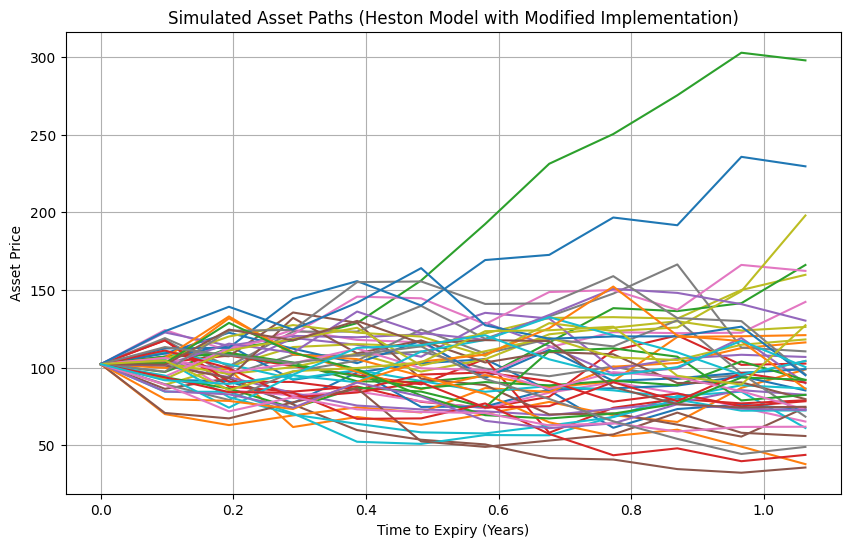

In [94]:
timeStepsPerYear = 12  # monthly time steps
iterations = 10000  # number of Monte Carlo paths
timesteps = int(T * timeStepsPerYear)
dt = 1 / timeStepsPerYear

# Containers for St and Vt
S_t = np.zeros((timesteps, iterations))
V_t = np.zeros((timesteps, iterations))

V_t[0, :] = v_0_estimated
S_t[0, :] = S_0

# Generate correlated Gaussians
means = [0, 0]
stdevs = [1, 1]
covs = [[stdevs[0]**2, stdevs[0] * stdevs[1] * rho_estimated],
        [stdevs[0] * stdevs[1] * rho_estimated, stdevs[1]**2]]
Z = np.random.multivariate_normal(means, covs, (iterations, timesteps)).T
Z1 = Z[0]
Z2 = Z[1]

# Monte Carlo simulation using Euler's method for calculating SDE.
for i in range(1, timesteps):
    # Update Vt using Z2
    V_t[i, :] = np.maximum(V_t[i - 1, :] +
                           kappa_estimated * (theta_estimated - V_t[i - 1, :]) * dt +
                           sigma_estimated * np.sqrt(V_t[i - 1, :] * dt) * Z2[i, :], 0)
    
    # Update St using the new Vt and Z1
    S_t[i, :] = S_t[i - 1, :] + r_f * S_t[i - 1, :] * dt + \
                np.sqrt(V_t[i, :] * dt) * S_t[i - 1, :] * Z1[i, :]

plt.figure(figsize=(10, 6))
for i in range(50):
    plt.plot(np.linspace(0, T, timesteps), S_t[:, i])
plt.title('Simulated Asset Paths (Heston Model with Modified Implementation)')
plt.xlabel('Time to Expiry (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

In [86]:
unique_strike_prices = option_data_df['strike'].unique()
mc_option_prices = []

for K in unique_strike_prices:
    mc_option_price = np.mean(np.maximum(S_t[-1, :] - K, 0)) * np.exp(-r_f * T)
    mc_option_prices.append(mc_option_price)

comparison_df = pd.DataFrame({
    'Strike Price': unique_strike_prices,
    'MC Option Price': mc_option_prices,
})

merged_comparison_df = pd.merge(comparison_df, option_data_df[['strike', 'lastPrice']].drop_duplicates(), 
                                left_on='Strike Price', right_on='strike', how='inner')
merged_comparison_df = merged_comparison_df.drop(columns=['strike'])
merged_comparison_df.rename(columns={'lastPrice': 'Actual Option Price'}, inplace=True)

In [87]:
merged_comparison_df

,Strike Price,MC Option Price,Actual Option Price
0,30.0,72.149515,77.17
1,35.0,67.478387,71.97
2,40.0,62.860987,67.26
3,45.0,58.339369,63.85
4,50.0,53.931127,56.82
5,55.0,49.658958,54.51
6,60.0,45.551579,49.15
7,65.0,41.635151,44.80
8,70.0,37.928215,40.80
9,75.0,34.441466,37.50


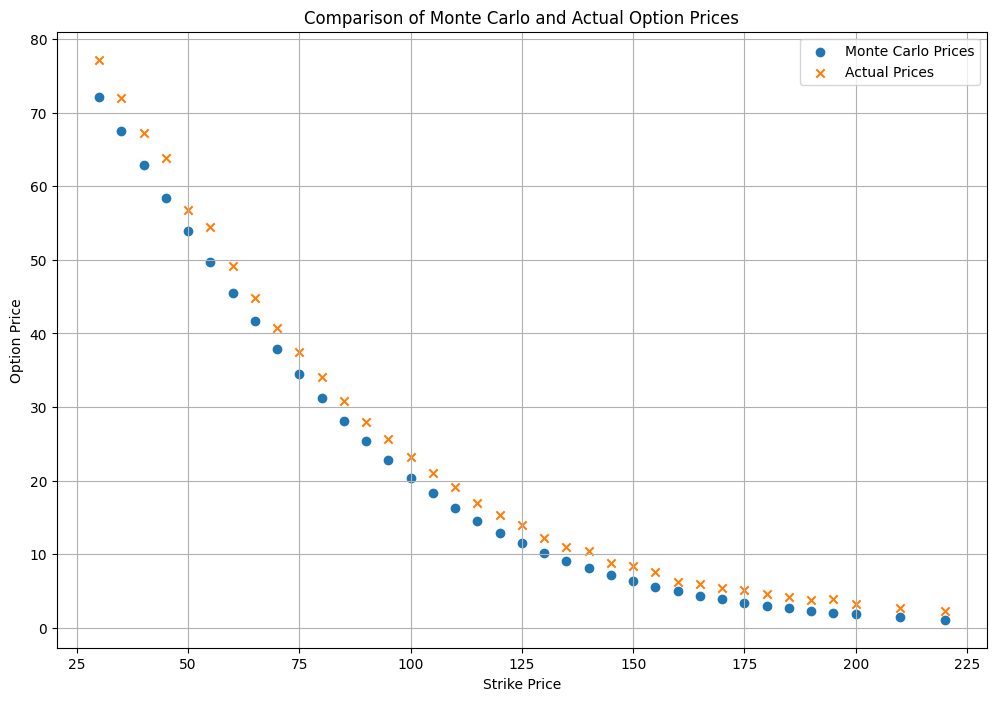

In [88]:
#visualizing the comparison between Monte Carlo and actual option prices
plt.figure(figsize=(12, 8))
plt.scatter(merged_comparison_df['Strike Price'], merged_comparison_df['MC Option Price'], label='Monte Carlo Prices', marker='o')
plt.scatter(merged_comparison_df['Strike Price'], merged_comparison_df['Actual Option Price'], label='Actual Prices', marker='x')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Comparison of Monte Carlo and Actual Option Prices')
plt.legend()
plt.grid(True)
plt.show()